In [25]:
%pylab inline
import sys
sys.path.append("/gymreklab-tscc/bonnieh/helper_functions")
from Joint_method_functions import *
import glob
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.ticker as ticker
import seaborn as sns
from statistics import mode
from scipy import stats

PLOTDIR = '/storage/BonnieH/selection_project/figures/figures/figure2/'

Populating the interactive namespace from numpy and matplotlib


In [26]:
# Given file, get ABC lookup table
def getABCTable(file):
    num_bins = 0
    
    # Return list of lists that contain [s, het, common]
    table = GetABCList(file, num_bins)
    dic_summ_stats = {}
        
    # Fill in dic_summ_stats: Key is s, value is list of het, number of common alleles pairs for given s value
    for combo in table:
        s_round = get_LRT_bin(combo[0])
        if s_round not in dic_summ_stats:
            dic_summ_stats[s_round] = []
        dic_summ_stats[s_round].append([combo[1], combo[2]]) # Append het, number of common alleles for s value
    
    return dic_summ_stats

In [27]:
def GetObsHetDistrFn(motif_to_use, opt):
    inFile = '/gymreklab-tscc/bonnieh/input_files/' + '1kg_allele_freqs_filt_intergenic.txt'
    
    allele_freqs_file = open(inFile, 'r')
    
    obs_het_distr_all = []
    obs_common_distr_all = []
    opt_allele_list = []
    count = 0
   
    # Get STRs (represented by optimal allele list) to estimate s jointly on
    # Get observed het and common alleles distribution on these STRs
    for line in allele_freqs_file:
        
        # Get information from line
        info = line.strip().split('\t')
        chrom = info[0]
        start = int(info[1])
        end = int(info[2])
        freqs = info[3]
        per = int(info[5])
        motif = info[6]
        
        canonical_motif = GetCanonicalRU(motif)
            
        
        opt_allele, allele_freqs = Process_Freqs(freqs, per, end, start, True, True)
        
        if canonical_motif == motif_to_use and per == len(motif_to_use) and (opt == 0 or opt == opt_allele):
            
            count = count + 1
            obs_het = 1-sum([item**2 for item in allele_freqs])
            obs_common = len([i for i in allele_freqs if i >= 0.05])
            obs_het_distr_all.append(obs_het)
            obs_common_distr_all.append(obs_common)
            opt_allele_list.append((per, opt_allele))
                   
    allele_freqs_file.close()
   
    opt_allele_sub_list = []
    obs_het_distr = []
    obs_common_distr = []
    total_number_loci = len(opt_allele_list)
    
    if len(opt_allele_list) <= 1000:
        opt_allele_sub_list = opt_allele_list
        obs_het_distr = obs_het_distr_all
        obs_common_distr = obs_common_distr_all
      
    # Get random heterozygosity and number of common alleles distributions
    else:
        
        divisor = int(len(opt_allele_list)/1000) + 2
        num_loci_added = 0
        while num_loci_added < 1000:
            divisor = divisor * num_loci_added + 5
            if divisor > len(opt_allele_list):
                divisor = divisor%len(opt_allele_list)
            
            toAdd = opt_allele_list.pop(divisor)
            opt_allele_sub_list.append(toAdd)
            toAddHet = obs_het_distr_all.pop(divisor)
            obs_het_distr.append(toAddHet)
            toAddComm = obs_common_distr_all.pop(divisor)
            obs_common_distr.append(toAddComm)
            num_loci_added = num_loci_added + 1
    
    return obs_het_distr, opt_allele_sub_list

In [28]:
# Different colormap options: 'binary', 'hot_r', 'Blues', 'YlGnBu', 'Greens', 'viridis', 'cool'
def main():
    
    pval_threshold = 0.05
    goodness_of_fit_file = open('goodness_of_fit.txt','w')
    
    print('Running main')
    combos = [(2, 'intergenic'),(3, 'intergenic'),(4, 'intergenic')]
    superfolder = 'results_intergenic_top_x'
    subfolder = '1kg_bin_agnostic_redo'
    colormap = 'Blues'
    
    num_files_dict = {} # Key: Period, Value: Number of files
    num_files_dict[2] = 30
    num_files_dict[3] = 72
    num_files_dict[4] = 36
    
    opt_dic = {}
    opt_dic[2] = ['11','12','13','14','15','16','17','18','19','20']
    opt_dic[3] = ['05','06','07','08','09','10','11','12','13']
    opt_dic[4] = ['07','08','09','10']
    
    
    motif_dic = {}
    motif_dic[2] = ['AT','AG','AC']
    
    motif_dic[3] = ['AAT','ATC','AAG','AGG','AGC','CCG','AAC','ACC'] 
    
    motif_dic[4] = ['AAAT','AATC','AATG','ATCC','AAAG','AAGG','AGAT','AAAC','ACAT']
    
    mut_setting_dic = {}
    mut_setting_dic[2] = ['a','b','c','d','e','f']
    mut_setting_dic[3] = ['a','b','c','d','e','f','g']
    mut_setting_dic[4] = ['a','b','c','d','e','f','g']
    
    file_name_dic = {}
    file_name_dic[2] = 'dinuc'
    file_name_dic[3] = 'trinuc'
    file_name_dic[4] = 'tetranuc'
    
    for combo in combos:
        
        per = combo[0]
        list_of_percents = []
        list_of_num_loci = []
        list_of_pvalue= []

        # Plot heatmap for each motif in given period
        for i in range(0,1):
            for motif in motif_dic[per]:
                for opt in opt_dic[per]:
                    file_list = glob.glob('/gymreklab-tscc/bonnieh/joint_method/%s/%s/per_%d_*%s*opt_%s.txt'%(superfolder, subfolder, per, motif, opt))
                    
                    if 1>0:
                        filename = file_list[0]
                        results_file = open(filename, 'r')
                        
                        for k in range(0, 2):
                            line= results_file.readline()
                        
                        info = line.strip().split(': ')
                        num_loci = info[1]
                        num_loci = num_loci.strip().split(' ')
                        num_loci = int(num_loci[0])
                        
                        list_of_num_loci.append(num_loci)
                        
                        if num_loci == 0:
                           
                            for elem in mut_setting_dic[per]:
                                list_of_percents.append(0)
                                list_of_pvalue.append(0)
                        
                        else:
                            for k in range(0, 9):
                                line= results_file.readline()
                            info = line.strip().split(': ')
                            list_settings = info[1]
                            list_settings = list_settings.strip().split(', ')
                            
                            for elem in mut_setting_dic[per]:
                                num_acc = list_settings.count(elem)
                                
                                list_of_percents.append(num_acc)
                            
                            # Find mode of list_settings:
                            #mode_setting = mode(list_settings)
                            #print(stats.mode(list_settings))
                            mode, count = stats.mode(list_settings)
                            mode_setting = mode[0]
                            print((motif,opt))
                            print(mode_setting)
                            
                            # Get observed heterozygosity 
                            if opt[0] == '0':
                                opt_num=int(opt[1]) 
                            else:
                                opt_num=int(opt)
                                
                            goodness_of_fit_file.write(motif + '\t' + str(opt_num) + '\t' + mode_setting + '\n')
                            obs_het_distr, opt_allele_sub_list = GetObsHetDistrFn(motif, opt_num)
                            
                            # Get simulated heterozygosity

                            mut_setting_folder_name = {}
                            mut_setting_folder_name[2] = 'eurodem_prior2_dinuc_'
                            mut_setting_folder_name[3] = 'eurodem_prior2_trinuc_'
                            mut_setting_folder_name[4] = 'eurodem_prior2_tetranuc_'

                            folder_prefix = mut_setting_folder_name[len(motif)]
                            
                            file = '/gymreklab-tscc/bonnieh/abc/results/' + folder_prefix + mode_setting + '/' + str(len(motif)) + '_' + str(opt_num) + '.txt'

                            ABC_dic = {}
                            ABC_dic[opt_num] = getABCTable(file)
                            
                            ABC_tables_mut = ABC_dic
                            count = 0
                            for zz in range(0, 100):
                                sim_het_list, sim_common_list = GetLists(ABC_tables_mut, opt_allele_sub_list, 2, 10**-3)

                                ks_stat, pval = stats.ks_2samp(obs_het_distr, sim_het_list)
                                if pval > pval_threshold:
                                    count = count + 1
                                #if pval < 0.05:
                                    #list_of_pvalue.append(0)
                                #else:
                                    #list_of_pvalue.append(1)
                                    
                            list_of_pvalue.append(count)
                            print(count)
                            
                        results_file.close()
        matrix = np.zeros((len(motif_dic[per]), len(opt_dic[per])))
        #print(matrix)
        counter = 0

        for i in range(len(motif_dic[per])): 
            for j in range(len(opt_dic[per])):
                #print(i,j)
                matrix[i,j] = list_of_pvalue[counter]
                counter = counter + 1

        # Visualize heatmap

        print(matrix)
        
        opt = []
        
        for opt_num in opt_dic[per]:
            if opt_num[0] == '0':
                opt.append(opt_num[1]) #mot + ' ' 
            else:
                opt.append(opt_num)

        print(matrix)
        fig, ax = plt.subplots()
        
        im = ax.imshow(matrix,cmap=colormap) 
        cbar = fig.colorbar(im)
        cbar.ax.set_ylabel('Percent simulations with good fit')

        # Show all ticks
        ax.set_xticks(np.arange(len(opt)))
        ax.set_yticks(np.arange(len(motif_dic[per])))

        # Label ticks
        ax.set_xticklabels(opt)
        ax.set_yticklabels(motif_dic[per])

        if per == 2:
            ax.set_title('Dinucleotides',fontsize=20)
        if per == 3:
            ax.set_title('Trinucleotides',fontsize=20)
        if per == 4:
            ax.set_title('Tetranucleotides',fontsize=20)
        
        #plt.savefig(PLOTDIR + 'heatmap_%d_%s_w_cbar.pdf'%(per, combo[1]),bbox_inches='tight')
        plt.yticks(size=15)
        plt.xticks(size=15)
        fig.tight_layout()
    goodness_of_fit_file.close()

Running main
('AT', '11')
d
48
('AT', '12')
d
82
('AT', '13')
c
49
('AT', '14')
c
58
('AT', '15')
c
77
('AT', '16')
c
40
('AT', '17')
c
100
('AT', '18')
d
87
('AT', '19')
d
68
('AT', '20')
f
100
('AG', '11')
f
61
('AG', '12')
f
100
('AG', '13')
e
81
('AG', '14')
f
93
('AG', '15')
e
100
('AG', '16')
e
99
('AG', '17')
e
84
('AG', '18')
e
100
('AG', '19')
e
100
('AG', '20')
d
99
('AC', '11')
e
0
('AC', '12')
e
96
('AC', '13')
e
96
('AC', '14')
e
82
('AC', '15')
e
96
('AC', '16')
e
78
('AC', '17')
e
1
('AC', '18')
e
0
('AC', '19')
f
5
('AC', '20')
f
0
[[ 48.  82.  49.  58.  77.  40. 100.  87.  68. 100.]
 [ 61. 100.  81.  93. 100.  99.  84. 100. 100.  99.]
 [  0.  96.  96.  82.  96.  78.   1.   0.   5.   0.]]
[[ 48.  82.  49.  58.  77.  40. 100.  87.  68. 100.]
 [ 61. 100.  81.  93. 100.  99.  84. 100. 100.  99.]
 [  0.  96.  96.  82.  96.  78.   1.   0.   5.   0.]]
('AAT', '05')
e
0
('AAT', '06')
e
0
('AAT', '07')
e
0
('AAT', '08')
d
79
('AAT', '09')
c
5
('AAT', '10')
c
0
('AAT', '11')
a
0

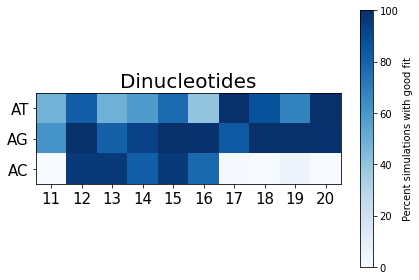

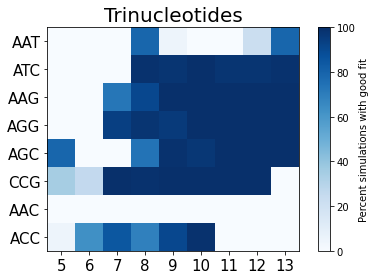

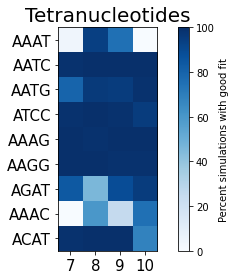

In [29]:
%%time
if __name__ == '__main__':
    main()